# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [3]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [4]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [5]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [6]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [7]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                output = model.forward(images)
        probabilities = F.softmax(output, dim = 1)
        top_p, top_class = probabilities.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        print(f'Accuracy: {accuracy.item()*100}%')

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [16]:
## TODO: Define your model with dropout added
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 3 Hidden Layers of 256, 128, and 64
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # 25% drop out rate of layors
        self.dropout = nn.Dropout(p = 0.25)
    
    def forward(self, x):
        # flatten tensor
        x = x.view(x.shape[0], -1)
        
        # Layors with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output without dropout
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
        
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [17]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
epochs = 10

for e in range(epochs):
    training_loss = 0
    testing_loss = 0

    for images, labels in trainloader:

        # Training Output & Loss
        output = model(images)
        loss = criterion(output, labels)
        training_loss += loss.item()
        
        # Autograd
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    else:
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                # Prediction & Testing Loss
                prediction = model(images)
                loss = criterion(prediction, labels)
                testing_loss += loss.item()

        # Calculate probability & accuracy
        probabilities = F.softmax(prediction, dim = 1)
        top_probability, top_class = probabilities.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        
        print('Step {} - Training Loss: {:.3F}, Testing Loss: {:.3F}, Testing Accuracy: {:.2F}%'.format(
              e+1, training_loss/len(trainloader), testing_loss/len(testloader), accuracy*100))
        model.train()

torch.Size([64, 1, 28, 28])
CPU  1
torch.Size([64, 1, 28, 28])
CPU  2
torch.Size([64, 1, 28, 28])
CPU  3
torch.Size([64, 1, 28, 28])
CPU  4
torch.Size([64, 1, 28, 28])
CPU  5
torch.Size([64, 1, 28, 28])
CPU  6
torch.Size([64, 1, 28, 28])
CPU  7
torch.Size([64, 1, 28, 28])
CPU  8
torch.Size([64, 1, 28, 28])
CPU  9
torch.Size([64, 1, 28, 28])
CPU  10
torch.Size([64, 1, 28, 28])
CPU  11
torch.Size([64, 1, 28, 28])
CPU  12
torch.Size([64, 1, 28, 28])
CPU  13
torch.Size([64, 1, 28, 28])
CPU  14
torch.Size([64, 1, 28, 28])
CPU  15
torch.Size([64, 1, 28, 28])
CPU  16
torch.Size([64, 1, 28, 28])
CPU  17
torch.Size([64, 1, 28, 28])
CPU  18
torch.Size([64, 1, 28, 28])
CPU  19
torch.Size([64, 1, 28, 28])
CPU  20
torch.Size([64, 1, 28, 28])
CPU  21
torch.Size([64, 1, 28, 28])
CPU  22
torch.Size([64, 1, 28, 28])
CPU  23
torch.Size([64, 1, 28, 28])
CPU  24
torch.Size([64, 1, 28, 28])
CPU  25
torch.Size([64, 1, 28, 28])
CPU  26
torch.Size([64, 1, 28, 28])
CPU  27
torch.Size([64, 1, 28, 28])
CPU  28
t

torch.Size([64, 1, 28, 28])
CPU  242
torch.Size([64, 1, 28, 28])
CPU  243
torch.Size([64, 1, 28, 28])
CPU  244
torch.Size([64, 1, 28, 28])
CPU  245
torch.Size([64, 1, 28, 28])
CPU  246
torch.Size([64, 1, 28, 28])
CPU  247
torch.Size([64, 1, 28, 28])
CPU  248
torch.Size([64, 1, 28, 28])
CPU  249
torch.Size([64, 1, 28, 28])
CPU  250
torch.Size([64, 1, 28, 28])
CPU  251
torch.Size([64, 1, 28, 28])
CPU  252
torch.Size([64, 1, 28, 28])
CPU  253
torch.Size([64, 1, 28, 28])
CPU  254
torch.Size([64, 1, 28, 28])
CPU  255
torch.Size([64, 1, 28, 28])
CPU  256
torch.Size([64, 1, 28, 28])
CPU  257
torch.Size([64, 1, 28, 28])
CPU  258
torch.Size([64, 1, 28, 28])
CPU  259
torch.Size([64, 1, 28, 28])
CPU  260
torch.Size([64, 1, 28, 28])
CPU  261
torch.Size([64, 1, 28, 28])
CPU  262
torch.Size([64, 1, 28, 28])
CPU  263
torch.Size([64, 1, 28, 28])
CPU  264
torch.Size([64, 1, 28, 28])
CPU  265
torch.Size([64, 1, 28, 28])
CPU  266
torch.Size([64, 1, 28, 28])
CPU  267
torch.Size([64, 1, 28, 28])
CPU  268
t

torch.Size([64, 1, 28, 28])
CPU  482
torch.Size([64, 1, 28, 28])
CPU  483
torch.Size([64, 1, 28, 28])
CPU  484
torch.Size([64, 1, 28, 28])
CPU  485
torch.Size([64, 1, 28, 28])
CPU  486
torch.Size([64, 1, 28, 28])
CPU  487
torch.Size([64, 1, 28, 28])
CPU  488
torch.Size([64, 1, 28, 28])
CPU  489
torch.Size([64, 1, 28, 28])
CPU  490
torch.Size([64, 1, 28, 28])
CPU  491
torch.Size([64, 1, 28, 28])
CPU  492
torch.Size([64, 1, 28, 28])
CPU  493
torch.Size([64, 1, 28, 28])
CPU  494
torch.Size([64, 1, 28, 28])
CPU  495
torch.Size([64, 1, 28, 28])
CPU  496
torch.Size([64, 1, 28, 28])
CPU  497
torch.Size([64, 1, 28, 28])
CPU  498
torch.Size([64, 1, 28, 28])
CPU  499
torch.Size([64, 1, 28, 28])
CPU  500
torch.Size([64, 1, 28, 28])
CPU  501
torch.Size([64, 1, 28, 28])
CPU  502
torch.Size([64, 1, 28, 28])
CPU  503
torch.Size([64, 1, 28, 28])
CPU  504
torch.Size([64, 1, 28, 28])
CPU  505
torch.Size([64, 1, 28, 28])
CPU  506
torch.Size([64, 1, 28, 28])
CPU  507
torch.Size([64, 1, 28, 28])
CPU  508
t

torch.Size([64, 1, 28, 28])
CPU  706
torch.Size([64, 1, 28, 28])
CPU  707
torch.Size([64, 1, 28, 28])
CPU  708
torch.Size([64, 1, 28, 28])
CPU  709
torch.Size([64, 1, 28, 28])
CPU  710
torch.Size([64, 1, 28, 28])
CPU  711
torch.Size([64, 1, 28, 28])
CPU  712
torch.Size([64, 1, 28, 28])
CPU  713
torch.Size([64, 1, 28, 28])
CPU  714
torch.Size([64, 1, 28, 28])
CPU  715
torch.Size([64, 1, 28, 28])
CPU  716
torch.Size([64, 1, 28, 28])
CPU  717
torch.Size([64, 1, 28, 28])
CPU  718
torch.Size([64, 1, 28, 28])
CPU  719
torch.Size([64, 1, 28, 28])
CPU  720
torch.Size([64, 1, 28, 28])
CPU  721
torch.Size([64, 1, 28, 28])
CPU  722
torch.Size([64, 1, 28, 28])
CPU  723
torch.Size([64, 1, 28, 28])
CPU  724
torch.Size([64, 1, 28, 28])
CPU  725
torch.Size([64, 1, 28, 28])
CPU  726
torch.Size([64, 1, 28, 28])
CPU  727
torch.Size([64, 1, 28, 28])
CPU  728
torch.Size([64, 1, 28, 28])
CPU  729
torch.Size([64, 1, 28, 28])
CPU  730
torch.Size([64, 1, 28, 28])
CPU  731
torch.Size([64, 1, 28, 28])
CPU  732
t

Step 1 - Training Loss: 0.634, Testing Loss: 0.478, Testing Accuracy: 68.75%
torch.Size([64, 1, 28, 28])
CPU  1
torch.Size([64, 1, 28, 28])
CPU  2
torch.Size([64, 1, 28, 28])
CPU  3
torch.Size([64, 1, 28, 28])
CPU  4
torch.Size([64, 1, 28, 28])
CPU  5
torch.Size([64, 1, 28, 28])
CPU  6
torch.Size([64, 1, 28, 28])
CPU  7
torch.Size([64, 1, 28, 28])
CPU  8
torch.Size([64, 1, 28, 28])
CPU  9
torch.Size([64, 1, 28, 28])
CPU  10
torch.Size([64, 1, 28, 28])
CPU  11
torch.Size([64, 1, 28, 28])
CPU  12
torch.Size([64, 1, 28, 28])
CPU  13
torch.Size([64, 1, 28, 28])
CPU  14
torch.Size([64, 1, 28, 28])
CPU  15
torch.Size([64, 1, 28, 28])
CPU  16
torch.Size([64, 1, 28, 28])
CPU  17
torch.Size([64, 1, 28, 28])
CPU  18
torch.Size([64, 1, 28, 28])
CPU  19
torch.Size([64, 1, 28, 28])
CPU  20
torch.Size([64, 1, 28, 28])
CPU  21
torch.Size([64, 1, 28, 28])
CPU  22
torch.Size([64, 1, 28, 28])
CPU  23
torch.Size([64, 1, 28, 28])
CPU  24
torch.Size([64, 1, 28, 28])
CPU  25
torch.Size([64, 1, 28, 28])
CPU 

torch.Size([64, 1, 28, 28])
CPU  224
torch.Size([64, 1, 28, 28])
CPU  225
torch.Size([64, 1, 28, 28])
CPU  226
torch.Size([64, 1, 28, 28])
CPU  227
torch.Size([64, 1, 28, 28])
CPU  228
torch.Size([64, 1, 28, 28])
CPU  229
torch.Size([64, 1, 28, 28])
CPU  230
torch.Size([64, 1, 28, 28])
CPU  231
torch.Size([64, 1, 28, 28])
CPU  232
torch.Size([64, 1, 28, 28])
CPU  233
torch.Size([64, 1, 28, 28])
CPU  234
torch.Size([64, 1, 28, 28])
CPU  235
torch.Size([64, 1, 28, 28])
CPU  236
torch.Size([64, 1, 28, 28])
CPU  237
torch.Size([64, 1, 28, 28])
CPU  238
torch.Size([64, 1, 28, 28])
CPU  239
torch.Size([64, 1, 28, 28])
CPU  240
torch.Size([64, 1, 28, 28])
CPU  241
torch.Size([64, 1, 28, 28])
CPU  242
torch.Size([64, 1, 28, 28])
CPU  243
torch.Size([64, 1, 28, 28])
CPU  244
torch.Size([64, 1, 28, 28])
CPU  245
torch.Size([64, 1, 28, 28])
CPU  246
torch.Size([64, 1, 28, 28])
CPU  247
torch.Size([64, 1, 28, 28])
CPU  248
torch.Size([64, 1, 28, 28])
CPU  249
torch.Size([64, 1, 28, 28])
CPU  250
t

torch.Size([64, 1, 28, 28])
CPU  456
torch.Size([64, 1, 28, 28])
CPU  457
torch.Size([64, 1, 28, 28])
CPU  458
torch.Size([64, 1, 28, 28])
CPU  459
torch.Size([64, 1, 28, 28])
CPU  460
torch.Size([64, 1, 28, 28])
CPU  461
torch.Size([64, 1, 28, 28])
CPU  462
torch.Size([64, 1, 28, 28])
CPU  463
torch.Size([64, 1, 28, 28])
CPU  464
torch.Size([64, 1, 28, 28])
CPU  465
torch.Size([64, 1, 28, 28])
CPU  466
torch.Size([64, 1, 28, 28])
CPU  467
torch.Size([64, 1, 28, 28])
CPU  468
torch.Size([64, 1, 28, 28])
CPU  469
torch.Size([64, 1, 28, 28])
CPU  470
torch.Size([64, 1, 28, 28])
CPU  471
torch.Size([64, 1, 28, 28])
CPU  472
torch.Size([64, 1, 28, 28])
CPU  473
torch.Size([64, 1, 28, 28])
CPU  474
torch.Size([64, 1, 28, 28])
CPU  475
torch.Size([64, 1, 28, 28])
CPU  476
torch.Size([64, 1, 28, 28])
CPU  477
torch.Size([64, 1, 28, 28])
CPU  478
torch.Size([64, 1, 28, 28])
CPU  479
torch.Size([64, 1, 28, 28])
CPU  480
torch.Size([64, 1, 28, 28])
CPU  481
torch.Size([64, 1, 28, 28])
CPU  482
t

torch.Size([64, 1, 28, 28])
CPU  691
torch.Size([64, 1, 28, 28])
CPU  692
torch.Size([64, 1, 28, 28])
CPU  693
torch.Size([64, 1, 28, 28])
CPU  694
torch.Size([64, 1, 28, 28])
CPU  695
torch.Size([64, 1, 28, 28])
CPU  696
torch.Size([64, 1, 28, 28])
CPU  697
torch.Size([64, 1, 28, 28])
CPU  698
torch.Size([64, 1, 28, 28])
CPU  699
torch.Size([64, 1, 28, 28])
CPU  700
torch.Size([64, 1, 28, 28])
CPU  701
torch.Size([64, 1, 28, 28])
CPU  702
torch.Size([64, 1, 28, 28])
CPU  703
torch.Size([64, 1, 28, 28])
CPU  704
torch.Size([64, 1, 28, 28])
CPU  705
torch.Size([64, 1, 28, 28])
CPU  706
torch.Size([64, 1, 28, 28])
CPU  707
torch.Size([64, 1, 28, 28])
CPU  708
torch.Size([64, 1, 28, 28])
CPU  709
torch.Size([64, 1, 28, 28])
CPU  710
torch.Size([64, 1, 28, 28])
CPU  711
torch.Size([64, 1, 28, 28])
CPU  712
torch.Size([64, 1, 28, 28])
CPU  713
torch.Size([64, 1, 28, 28])
CPU  714
torch.Size([64, 1, 28, 28])
CPU  715
torch.Size([64, 1, 28, 28])
CPU  716
torch.Size([64, 1, 28, 28])
CPU  717
t

torch.Size([64, 1, 28, 28])
CPU  926
torch.Size([64, 1, 28, 28])
CPU  927
torch.Size([64, 1, 28, 28])
CPU  928
torch.Size([64, 1, 28, 28])
CPU  929
torch.Size([64, 1, 28, 28])
CPU  930
torch.Size([64, 1, 28, 28])
CPU  931
torch.Size([64, 1, 28, 28])
CPU  932
torch.Size([64, 1, 28, 28])
CPU  933
torch.Size([64, 1, 28, 28])
CPU  934
torch.Size([64, 1, 28, 28])
CPU  935
torch.Size([64, 1, 28, 28])
CPU  936
torch.Size([64, 1, 28, 28])
CPU  937
torch.Size([32, 1, 28, 28])
CPU  938
Step 2 - Training Loss: 0.512, Testing Loss: 0.464, Testing Accuracy: 87.50%
torch.Size([64, 1, 28, 28])
CPU  1
torch.Size([64, 1, 28, 28])
CPU  2
torch.Size([64, 1, 28, 28])
CPU  3
torch.Size([64, 1, 28, 28])
CPU  4
torch.Size([64, 1, 28, 28])
CPU  5
torch.Size([64, 1, 28, 28])
CPU  6
torch.Size([64, 1, 28, 28])
CPU  7
torch.Size([64, 1, 28, 28])
CPU  8
torch.Size([64, 1, 28, 28])
CPU  9
torch.Size([64, 1, 28, 28])
CPU  10
torch.Size([64, 1, 28, 28])
CPU  11
torch.Size([64, 1, 28, 28])
CPU  12
torch.Size([64, 1, 

torch.Size([64, 1, 28, 28])
CPU  215
torch.Size([64, 1, 28, 28])
CPU  216
torch.Size([64, 1, 28, 28])
CPU  217
torch.Size([64, 1, 28, 28])
CPU  218
torch.Size([64, 1, 28, 28])
CPU  219
torch.Size([64, 1, 28, 28])
CPU  220
torch.Size([64, 1, 28, 28])
CPU  221
torch.Size([64, 1, 28, 28])
CPU  222
torch.Size([64, 1, 28, 28])
CPU  223
torch.Size([64, 1, 28, 28])
CPU  224
torch.Size([64, 1, 28, 28])
CPU  225
torch.Size([64, 1, 28, 28])
CPU  226
torch.Size([64, 1, 28, 28])
CPU  227
torch.Size([64, 1, 28, 28])
CPU  228
torch.Size([64, 1, 28, 28])
CPU  229
torch.Size([64, 1, 28, 28])
CPU  230
torch.Size([64, 1, 28, 28])
CPU  231
torch.Size([64, 1, 28, 28])
CPU  232
torch.Size([64, 1, 28, 28])
CPU  233
torch.Size([64, 1, 28, 28])
CPU  234
torch.Size([64, 1, 28, 28])
CPU  235
torch.Size([64, 1, 28, 28])
CPU  236
torch.Size([64, 1, 28, 28])
CPU  237
torch.Size([64, 1, 28, 28])
CPU  238
torch.Size([64, 1, 28, 28])
CPU  239
torch.Size([64, 1, 28, 28])
CPU  240
torch.Size([64, 1, 28, 28])
CPU  241
t

torch.Size([64, 1, 28, 28])
CPU  447
torch.Size([64, 1, 28, 28])
CPU  448
torch.Size([64, 1, 28, 28])
CPU  449
torch.Size([64, 1, 28, 28])
CPU  450
torch.Size([64, 1, 28, 28])
CPU  451
torch.Size([64, 1, 28, 28])
CPU  452
torch.Size([64, 1, 28, 28])
CPU  453
torch.Size([64, 1, 28, 28])
CPU  454
torch.Size([64, 1, 28, 28])
CPU  455
torch.Size([64, 1, 28, 28])
CPU  456
torch.Size([64, 1, 28, 28])
CPU  457
torch.Size([64, 1, 28, 28])
CPU  458
torch.Size([64, 1, 28, 28])
CPU  459
torch.Size([64, 1, 28, 28])
CPU  460
torch.Size([64, 1, 28, 28])
CPU  461
torch.Size([64, 1, 28, 28])
CPU  462
torch.Size([64, 1, 28, 28])
CPU  463
torch.Size([64, 1, 28, 28])
CPU  464
torch.Size([64, 1, 28, 28])
CPU  465
torch.Size([64, 1, 28, 28])
CPU  466
torch.Size([64, 1, 28, 28])
CPU  467
torch.Size([64, 1, 28, 28])
CPU  468
torch.Size([64, 1, 28, 28])
CPU  469
torch.Size([64, 1, 28, 28])
CPU  470
torch.Size([64, 1, 28, 28])
CPU  471
torch.Size([64, 1, 28, 28])
CPU  472
torch.Size([64, 1, 28, 28])
CPU  473
t

torch.Size([64, 1, 28, 28])
CPU  673
torch.Size([64, 1, 28, 28])
CPU  674
torch.Size([64, 1, 28, 28])
CPU  675
torch.Size([64, 1, 28, 28])
CPU  676
torch.Size([64, 1, 28, 28])
CPU  677
torch.Size([64, 1, 28, 28])
CPU  678
torch.Size([64, 1, 28, 28])
CPU  679
torch.Size([64, 1, 28, 28])
CPU  680
torch.Size([64, 1, 28, 28])
CPU  681
torch.Size([64, 1, 28, 28])
CPU  682
torch.Size([64, 1, 28, 28])
CPU  683
torch.Size([64, 1, 28, 28])
CPU  684
torch.Size([64, 1, 28, 28])
CPU  685
torch.Size([64, 1, 28, 28])
CPU  686
torch.Size([64, 1, 28, 28])
CPU  687
torch.Size([64, 1, 28, 28])
CPU  688
torch.Size([64, 1, 28, 28])
CPU  689
torch.Size([64, 1, 28, 28])
CPU  690
torch.Size([64, 1, 28, 28])
CPU  691
torch.Size([64, 1, 28, 28])
CPU  692
torch.Size([64, 1, 28, 28])
CPU  693
torch.Size([64, 1, 28, 28])
CPU  694
torch.Size([64, 1, 28, 28])
CPU  695
torch.Size([64, 1, 28, 28])
CPU  696
torch.Size([64, 1, 28, 28])
CPU  697
torch.Size([64, 1, 28, 28])
CPU  698
torch.Size([64, 1, 28, 28])
CPU  699
t

torch.Size([64, 1, 28, 28])
CPU  901
torch.Size([64, 1, 28, 28])
CPU  902
torch.Size([64, 1, 28, 28])
CPU  903
torch.Size([64, 1, 28, 28])
CPU  904
torch.Size([64, 1, 28, 28])
CPU  905
torch.Size([64, 1, 28, 28])
CPU  906
torch.Size([64, 1, 28, 28])
CPU  907
torch.Size([64, 1, 28, 28])
CPU  908
torch.Size([64, 1, 28, 28])
CPU  909
torch.Size([64, 1, 28, 28])
CPU  910
torch.Size([64, 1, 28, 28])
CPU  911
torch.Size([64, 1, 28, 28])
CPU  912
torch.Size([64, 1, 28, 28])
CPU  913
torch.Size([64, 1, 28, 28])
CPU  914
torch.Size([64, 1, 28, 28])
CPU  915
torch.Size([64, 1, 28, 28])
CPU  916
torch.Size([64, 1, 28, 28])
CPU  917
torch.Size([64, 1, 28, 28])
CPU  918
torch.Size([64, 1, 28, 28])
CPU  919
torch.Size([64, 1, 28, 28])
CPU  920
torch.Size([64, 1, 28, 28])
CPU  921
torch.Size([64, 1, 28, 28])
CPU  922
torch.Size([64, 1, 28, 28])
CPU  923
torch.Size([64, 1, 28, 28])
CPU  924
torch.Size([64, 1, 28, 28])
CPU  925
torch.Size([64, 1, 28, 28])
CPU  926
torch.Size([64, 1, 28, 28])
CPU  927
t

torch.Size([64, 1, 28, 28])
CPU  198
torch.Size([64, 1, 28, 28])
CPU  199
torch.Size([64, 1, 28, 28])
CPU  200
torch.Size([64, 1, 28, 28])
CPU  201
torch.Size([64, 1, 28, 28])
CPU  202
torch.Size([64, 1, 28, 28])
CPU  203
torch.Size([64, 1, 28, 28])
CPU  204
torch.Size([64, 1, 28, 28])
CPU  205
torch.Size([64, 1, 28, 28])
CPU  206
torch.Size([64, 1, 28, 28])
CPU  207
torch.Size([64, 1, 28, 28])
CPU  208
torch.Size([64, 1, 28, 28])
CPU  209
torch.Size([64, 1, 28, 28])
CPU  210
torch.Size([64, 1, 28, 28])
CPU  211
torch.Size([64, 1, 28, 28])
CPU  212
torch.Size([64, 1, 28, 28])
CPU  213
torch.Size([64, 1, 28, 28])
CPU  214
torch.Size([64, 1, 28, 28])
CPU  215
torch.Size([64, 1, 28, 28])
CPU  216
torch.Size([64, 1, 28, 28])
CPU  217
torch.Size([64, 1, 28, 28])
CPU  218
torch.Size([64, 1, 28, 28])
CPU  219
torch.Size([64, 1, 28, 28])
CPU  220
torch.Size([64, 1, 28, 28])
CPU  221
torch.Size([64, 1, 28, 28])
CPU  222
torch.Size([64, 1, 28, 28])
CPU  223
torch.Size([64, 1, 28, 28])
CPU  224
t

torch.Size([64, 1, 28, 28])
CPU  424
torch.Size([64, 1, 28, 28])
CPU  425
torch.Size([64, 1, 28, 28])
CPU  426
torch.Size([64, 1, 28, 28])
CPU  427
torch.Size([64, 1, 28, 28])
CPU  428
torch.Size([64, 1, 28, 28])
CPU  429
torch.Size([64, 1, 28, 28])
CPU  430
torch.Size([64, 1, 28, 28])
CPU  431
torch.Size([64, 1, 28, 28])
CPU  432
torch.Size([64, 1, 28, 28])
CPU  433
torch.Size([64, 1, 28, 28])
CPU  434
torch.Size([64, 1, 28, 28])
CPU  435
torch.Size([64, 1, 28, 28])
CPU  436
torch.Size([64, 1, 28, 28])
CPU  437
torch.Size([64, 1, 28, 28])
CPU  438
torch.Size([64, 1, 28, 28])
CPU  439
torch.Size([64, 1, 28, 28])
CPU  440
torch.Size([64, 1, 28, 28])
CPU  441
torch.Size([64, 1, 28, 28])
CPU  442
torch.Size([64, 1, 28, 28])
CPU  443
torch.Size([64, 1, 28, 28])
CPU  444
torch.Size([64, 1, 28, 28])
CPU  445
torch.Size([64, 1, 28, 28])
CPU  446
torch.Size([64, 1, 28, 28])
CPU  447
torch.Size([64, 1, 28, 28])
CPU  448
torch.Size([64, 1, 28, 28])
CPU  449
torch.Size([64, 1, 28, 28])
CPU  450
t

torch.Size([64, 1, 28, 28])
CPU  656
torch.Size([64, 1, 28, 28])
CPU  657
torch.Size([64, 1, 28, 28])
CPU  658
torch.Size([64, 1, 28, 28])
CPU  659
torch.Size([64, 1, 28, 28])
CPU  660
torch.Size([64, 1, 28, 28])
CPU  661
torch.Size([64, 1, 28, 28])
CPU  662
torch.Size([64, 1, 28, 28])
CPU  663
torch.Size([64, 1, 28, 28])
CPU  664
torch.Size([64, 1, 28, 28])
CPU  665
torch.Size([64, 1, 28, 28])
CPU  666
torch.Size([64, 1, 28, 28])
CPU  667
torch.Size([64, 1, 28, 28])
CPU  668
torch.Size([64, 1, 28, 28])
CPU  669
torch.Size([64, 1, 28, 28])
CPU  670
torch.Size([64, 1, 28, 28])
CPU  671
torch.Size([64, 1, 28, 28])
CPU  672
torch.Size([64, 1, 28, 28])
CPU  673
torch.Size([64, 1, 28, 28])
CPU  674
torch.Size([64, 1, 28, 28])
CPU  675
torch.Size([64, 1, 28, 28])
CPU  676
torch.Size([64, 1, 28, 28])
CPU  677
torch.Size([64, 1, 28, 28])
CPU  678
torch.Size([64, 1, 28, 28])
CPU  679
torch.Size([64, 1, 28, 28])
CPU  680
torch.Size([64, 1, 28, 28])
CPU  681
torch.Size([64, 1, 28, 28])
CPU  682
t

torch.Size([64, 1, 28, 28])
CPU  880
torch.Size([64, 1, 28, 28])
CPU  881
torch.Size([64, 1, 28, 28])
CPU  882
torch.Size([64, 1, 28, 28])
CPU  883
torch.Size([64, 1, 28, 28])
CPU  884
torch.Size([64, 1, 28, 28])
CPU  885
torch.Size([64, 1, 28, 28])
CPU  886
torch.Size([64, 1, 28, 28])
CPU  887
torch.Size([64, 1, 28, 28])
CPU  888
torch.Size([64, 1, 28, 28])
CPU  889
torch.Size([64, 1, 28, 28])
CPU  890
torch.Size([64, 1, 28, 28])
CPU  891
torch.Size([64, 1, 28, 28])
CPU  892
torch.Size([64, 1, 28, 28])
CPU  893
torch.Size([64, 1, 28, 28])
CPU  894
torch.Size([64, 1, 28, 28])
CPU  895
torch.Size([64, 1, 28, 28])
CPU  896
torch.Size([64, 1, 28, 28])
CPU  897
torch.Size([64, 1, 28, 28])
CPU  898
torch.Size([64, 1, 28, 28])
CPU  899
torch.Size([64, 1, 28, 28])
CPU  900
torch.Size([64, 1, 28, 28])
CPU  901
torch.Size([64, 1, 28, 28])
CPU  902
torch.Size([64, 1, 28, 28])
CPU  903
torch.Size([64, 1, 28, 28])
CPU  904
torch.Size([64, 1, 28, 28])
CPU  905
torch.Size([64, 1, 28, 28])
CPU  906
t

torch.Size([64, 1, 28, 28])
CPU  167
torch.Size([64, 1, 28, 28])
CPU  168
torch.Size([64, 1, 28, 28])
CPU  169
torch.Size([64, 1, 28, 28])
CPU  170
torch.Size([64, 1, 28, 28])
CPU  171
torch.Size([64, 1, 28, 28])
CPU  172
torch.Size([64, 1, 28, 28])
CPU  173
torch.Size([64, 1, 28, 28])
CPU  174
torch.Size([64, 1, 28, 28])
CPU  175
torch.Size([64, 1, 28, 28])
CPU  176
torch.Size([64, 1, 28, 28])
CPU  177
torch.Size([64, 1, 28, 28])
CPU  178
torch.Size([64, 1, 28, 28])
CPU  179
torch.Size([64, 1, 28, 28])
CPU  180
torch.Size([64, 1, 28, 28])
CPU  181
torch.Size([64, 1, 28, 28])
CPU  182
torch.Size([64, 1, 28, 28])
CPU  183
torch.Size([64, 1, 28, 28])
CPU  184
torch.Size([64, 1, 28, 28])
CPU  185
torch.Size([64, 1, 28, 28])
CPU  186
torch.Size([64, 1, 28, 28])
CPU  187
torch.Size([64, 1, 28, 28])
CPU  188
torch.Size([64, 1, 28, 28])
CPU  189
torch.Size([64, 1, 28, 28])
CPU  190
torch.Size([64, 1, 28, 28])
CPU  191
torch.Size([64, 1, 28, 28])
CPU  192
torch.Size([64, 1, 28, 28])
CPU  193
t

torch.Size([64, 1, 28, 28])
CPU  400
torch.Size([64, 1, 28, 28])
CPU  401
torch.Size([64, 1, 28, 28])
CPU  402
torch.Size([64, 1, 28, 28])
CPU  403
torch.Size([64, 1, 28, 28])
CPU  404
torch.Size([64, 1, 28, 28])
CPU  405
torch.Size([64, 1, 28, 28])
CPU  406
torch.Size([64, 1, 28, 28])
CPU  407
torch.Size([64, 1, 28, 28])
CPU  408
torch.Size([64, 1, 28, 28])
CPU  409
torch.Size([64, 1, 28, 28])
CPU  410
torch.Size([64, 1, 28, 28])
CPU  411
torch.Size([64, 1, 28, 28])
CPU  412
torch.Size([64, 1, 28, 28])
CPU  413
torch.Size([64, 1, 28, 28])
CPU  414
torch.Size([64, 1, 28, 28])
CPU  415
torch.Size([64, 1, 28, 28])
CPU  416
torch.Size([64, 1, 28, 28])
CPU  417
torch.Size([64, 1, 28, 28])
CPU  418
torch.Size([64, 1, 28, 28])
CPU  419
torch.Size([64, 1, 28, 28])
CPU  420
torch.Size([64, 1, 28, 28])
CPU  421
torch.Size([64, 1, 28, 28])
CPU  422
torch.Size([64, 1, 28, 28])
CPU  423
torch.Size([64, 1, 28, 28])
CPU  424
torch.Size([64, 1, 28, 28])
CPU  425
torch.Size([64, 1, 28, 28])
CPU  426
t

torch.Size([64, 1, 28, 28])
CPU  632
torch.Size([64, 1, 28, 28])
CPU  633
torch.Size([64, 1, 28, 28])
CPU  634
torch.Size([64, 1, 28, 28])
CPU  635
torch.Size([64, 1, 28, 28])
CPU  636
torch.Size([64, 1, 28, 28])
CPU  637
torch.Size([64, 1, 28, 28])
CPU  638
torch.Size([64, 1, 28, 28])
CPU  639
torch.Size([64, 1, 28, 28])
CPU  640
torch.Size([64, 1, 28, 28])
CPU  641
torch.Size([64, 1, 28, 28])
CPU  642
torch.Size([64, 1, 28, 28])
CPU  643
torch.Size([64, 1, 28, 28])
CPU  644
torch.Size([64, 1, 28, 28])
CPU  645
torch.Size([64, 1, 28, 28])
CPU  646
torch.Size([64, 1, 28, 28])
CPU  647
torch.Size([64, 1, 28, 28])
CPU  648
torch.Size([64, 1, 28, 28])
CPU  649
torch.Size([64, 1, 28, 28])
CPU  650
torch.Size([64, 1, 28, 28])
CPU  651
torch.Size([64, 1, 28, 28])
CPU  652
torch.Size([64, 1, 28, 28])
CPU  653
torch.Size([64, 1, 28, 28])
CPU  654
torch.Size([64, 1, 28, 28])
CPU  655
torch.Size([64, 1, 28, 28])
CPU  656
torch.Size([64, 1, 28, 28])
CPU  657
torch.Size([64, 1, 28, 28])
CPU  658
t

torch.Size([64, 1, 28, 28])
CPU  858
torch.Size([64, 1, 28, 28])
CPU  859
torch.Size([64, 1, 28, 28])
CPU  860
torch.Size([64, 1, 28, 28])
CPU  861
torch.Size([64, 1, 28, 28])
CPU  862
torch.Size([64, 1, 28, 28])
CPU  863
torch.Size([64, 1, 28, 28])
CPU  864
torch.Size([64, 1, 28, 28])
CPU  865
torch.Size([64, 1, 28, 28])
CPU  866
torch.Size([64, 1, 28, 28])
CPU  867
torch.Size([64, 1, 28, 28])
CPU  868
torch.Size([64, 1, 28, 28])
CPU  869
torch.Size([64, 1, 28, 28])
CPU  870
torch.Size([64, 1, 28, 28])
CPU  871
torch.Size([64, 1, 28, 28])
CPU  872
torch.Size([64, 1, 28, 28])
CPU  873
torch.Size([64, 1, 28, 28])
CPU  874
torch.Size([64, 1, 28, 28])
CPU  875
torch.Size([64, 1, 28, 28])
CPU  876
torch.Size([64, 1, 28, 28])
CPU  877
torch.Size([64, 1, 28, 28])
CPU  878
torch.Size([64, 1, 28, 28])
CPU  879
torch.Size([64, 1, 28, 28])
CPU  880
torch.Size([64, 1, 28, 28])
CPU  881
torch.Size([64, 1, 28, 28])
CPU  882
torch.Size([64, 1, 28, 28])
CPU  883
torch.Size([64, 1, 28, 28])
CPU  884
t

torch.Size([64, 1, 28, 28])
CPU  149
torch.Size([64, 1, 28, 28])
CPU  150
torch.Size([64, 1, 28, 28])
CPU  151
torch.Size([64, 1, 28, 28])
CPU  152
torch.Size([64, 1, 28, 28])
CPU  153
torch.Size([64, 1, 28, 28])
CPU  154
torch.Size([64, 1, 28, 28])
CPU  155
torch.Size([64, 1, 28, 28])
CPU  156
torch.Size([64, 1, 28, 28])
CPU  157
torch.Size([64, 1, 28, 28])
CPU  158
torch.Size([64, 1, 28, 28])
CPU  159
torch.Size([64, 1, 28, 28])
CPU  160
torch.Size([64, 1, 28, 28])
CPU  161
torch.Size([64, 1, 28, 28])
CPU  162
torch.Size([64, 1, 28, 28])
CPU  163
torch.Size([64, 1, 28, 28])
CPU  164
torch.Size([64, 1, 28, 28])
CPU  165
torch.Size([64, 1, 28, 28])
CPU  166
torch.Size([64, 1, 28, 28])
CPU  167
torch.Size([64, 1, 28, 28])
CPU  168
torch.Size([64, 1, 28, 28])
CPU  169
torch.Size([64, 1, 28, 28])
CPU  170
torch.Size([64, 1, 28, 28])
CPU  171
torch.Size([64, 1, 28, 28])
CPU  172
torch.Size([64, 1, 28, 28])
CPU  173
torch.Size([64, 1, 28, 28])
CPU  174
torch.Size([64, 1, 28, 28])
CPU  175
t

torch.Size([64, 1, 28, 28])
CPU  380
torch.Size([64, 1, 28, 28])
CPU  381
torch.Size([64, 1, 28, 28])
CPU  382
torch.Size([64, 1, 28, 28])
CPU  383
torch.Size([64, 1, 28, 28])
CPU  384
torch.Size([64, 1, 28, 28])
CPU  385
torch.Size([64, 1, 28, 28])
CPU  386
torch.Size([64, 1, 28, 28])
CPU  387
torch.Size([64, 1, 28, 28])
CPU  388
torch.Size([64, 1, 28, 28])
CPU  389
torch.Size([64, 1, 28, 28])
CPU  390
torch.Size([64, 1, 28, 28])
CPU  391
torch.Size([64, 1, 28, 28])
CPU  392
torch.Size([64, 1, 28, 28])
CPU  393
torch.Size([64, 1, 28, 28])
CPU  394
torch.Size([64, 1, 28, 28])
CPU  395
torch.Size([64, 1, 28, 28])
CPU  396
torch.Size([64, 1, 28, 28])
CPU  397
torch.Size([64, 1, 28, 28])
CPU  398
torch.Size([64, 1, 28, 28])
CPU  399
torch.Size([64, 1, 28, 28])
CPU  400
torch.Size([64, 1, 28, 28])
CPU  401
torch.Size([64, 1, 28, 28])
CPU  402
torch.Size([64, 1, 28, 28])
CPU  403
torch.Size([64, 1, 28, 28])
CPU  404
torch.Size([64, 1, 28, 28])
CPU  405
torch.Size([64, 1, 28, 28])
CPU  406
t

torch.Size([64, 1, 28, 28])
CPU  604
torch.Size([64, 1, 28, 28])
CPU  605
torch.Size([64, 1, 28, 28])
CPU  606
torch.Size([64, 1, 28, 28])
CPU  607
torch.Size([64, 1, 28, 28])
CPU  608
torch.Size([64, 1, 28, 28])
CPU  609
torch.Size([64, 1, 28, 28])
CPU  610
torch.Size([64, 1, 28, 28])
CPU  611
torch.Size([64, 1, 28, 28])
CPU  612
torch.Size([64, 1, 28, 28])
CPU  613
torch.Size([64, 1, 28, 28])
CPU  614
torch.Size([64, 1, 28, 28])
CPU  615
torch.Size([64, 1, 28, 28])
CPU  616
torch.Size([64, 1, 28, 28])
CPU  617
torch.Size([64, 1, 28, 28])
CPU  618
torch.Size([64, 1, 28, 28])
CPU  619
torch.Size([64, 1, 28, 28])
CPU  620
torch.Size([64, 1, 28, 28])
CPU  621
torch.Size([64, 1, 28, 28])
CPU  622
torch.Size([64, 1, 28, 28])
CPU  623
torch.Size([64, 1, 28, 28])
CPU  624
torch.Size([64, 1, 28, 28])
CPU  625
torch.Size([64, 1, 28, 28])
CPU  626
torch.Size([64, 1, 28, 28])
CPU  627
torch.Size([64, 1, 28, 28])
CPU  628
torch.Size([64, 1, 28, 28])
CPU  629
torch.Size([64, 1, 28, 28])
CPU  630
t

torch.Size([64, 1, 28, 28])
CPU  834
torch.Size([64, 1, 28, 28])
CPU  835
torch.Size([64, 1, 28, 28])
CPU  836
torch.Size([64, 1, 28, 28])
CPU  837
torch.Size([64, 1, 28, 28])
CPU  838
torch.Size([64, 1, 28, 28])
CPU  839
torch.Size([64, 1, 28, 28])
CPU  840
torch.Size([64, 1, 28, 28])
CPU  841
torch.Size([64, 1, 28, 28])
CPU  842
torch.Size([64, 1, 28, 28])
CPU  843
torch.Size([64, 1, 28, 28])
CPU  844
torch.Size([64, 1, 28, 28])
CPU  845
torch.Size([64, 1, 28, 28])
CPU  846
torch.Size([64, 1, 28, 28])
CPU  847
torch.Size([64, 1, 28, 28])
CPU  848
torch.Size([64, 1, 28, 28])
CPU  849
torch.Size([64, 1, 28, 28])
CPU  850
torch.Size([64, 1, 28, 28])
CPU  851
torch.Size([64, 1, 28, 28])
CPU  852
torch.Size([64, 1, 28, 28])
CPU  853
torch.Size([64, 1, 28, 28])
CPU  854
torch.Size([64, 1, 28, 28])
CPU  855
torch.Size([64, 1, 28, 28])
CPU  856
torch.Size([64, 1, 28, 28])
CPU  857
torch.Size([64, 1, 28, 28])
CPU  858
torch.Size([64, 1, 28, 28])
CPU  859
torch.Size([64, 1, 28, 28])
CPU  860
t

torch.Size([64, 1, 28, 28])
CPU  125
torch.Size([64, 1, 28, 28])
CPU  126
torch.Size([64, 1, 28, 28])
CPU  127
torch.Size([64, 1, 28, 28])
CPU  128
torch.Size([64, 1, 28, 28])
CPU  129
torch.Size([64, 1, 28, 28])
CPU  130
torch.Size([64, 1, 28, 28])
CPU  131
torch.Size([64, 1, 28, 28])
CPU  132
torch.Size([64, 1, 28, 28])
CPU  133
torch.Size([64, 1, 28, 28])
CPU  134
torch.Size([64, 1, 28, 28])
CPU  135
torch.Size([64, 1, 28, 28])
CPU  136
torch.Size([64, 1, 28, 28])
CPU  137
torch.Size([64, 1, 28, 28])
CPU  138
torch.Size([64, 1, 28, 28])
CPU  139
torch.Size([64, 1, 28, 28])
CPU  140
torch.Size([64, 1, 28, 28])
CPU  141
torch.Size([64, 1, 28, 28])
CPU  142
torch.Size([64, 1, 28, 28])
CPU  143
torch.Size([64, 1, 28, 28])
CPU  144
torch.Size([64, 1, 28, 28])
CPU  145
torch.Size([64, 1, 28, 28])
CPU  146
torch.Size([64, 1, 28, 28])
CPU  147
torch.Size([64, 1, 28, 28])
CPU  148
torch.Size([64, 1, 28, 28])
CPU  149
torch.Size([64, 1, 28, 28])
CPU  150
torch.Size([64, 1, 28, 28])
CPU  151
t

torch.Size([64, 1, 28, 28])
CPU  347
torch.Size([64, 1, 28, 28])
CPU  348
torch.Size([64, 1, 28, 28])
CPU  349
torch.Size([64, 1, 28, 28])
CPU  350
torch.Size([64, 1, 28, 28])
CPU  351
torch.Size([64, 1, 28, 28])
CPU  352
torch.Size([64, 1, 28, 28])
CPU  353
torch.Size([64, 1, 28, 28])
CPU  354
torch.Size([64, 1, 28, 28])
CPU  355
torch.Size([64, 1, 28, 28])
CPU  356
torch.Size([64, 1, 28, 28])
CPU  357
torch.Size([64, 1, 28, 28])
CPU  358
torch.Size([64, 1, 28, 28])
CPU  359
torch.Size([64, 1, 28, 28])
CPU  360
torch.Size([64, 1, 28, 28])
CPU  361
torch.Size([64, 1, 28, 28])
CPU  362
torch.Size([64, 1, 28, 28])
CPU  363
torch.Size([64, 1, 28, 28])
CPU  364
torch.Size([64, 1, 28, 28])
CPU  365
torch.Size([64, 1, 28, 28])
CPU  366
torch.Size([64, 1, 28, 28])
CPU  367
torch.Size([64, 1, 28, 28])
CPU  368
torch.Size([64, 1, 28, 28])
CPU  369
torch.Size([64, 1, 28, 28])
CPU  370
torch.Size([64, 1, 28, 28])
CPU  371
torch.Size([64, 1, 28, 28])
CPU  372
torch.Size([64, 1, 28, 28])
CPU  373
t

torch.Size([64, 1, 28, 28])
CPU  570
torch.Size([64, 1, 28, 28])
CPU  571
torch.Size([64, 1, 28, 28])
CPU  572
torch.Size([64, 1, 28, 28])
CPU  573
torch.Size([64, 1, 28, 28])
CPU  574
torch.Size([64, 1, 28, 28])
CPU  575
torch.Size([64, 1, 28, 28])
CPU  576
torch.Size([64, 1, 28, 28])
CPU  577
torch.Size([64, 1, 28, 28])
CPU  578
torch.Size([64, 1, 28, 28])
CPU  579
torch.Size([64, 1, 28, 28])
CPU  580
torch.Size([64, 1, 28, 28])
CPU  581
torch.Size([64, 1, 28, 28])
CPU  582
torch.Size([64, 1, 28, 28])
CPU  583
torch.Size([64, 1, 28, 28])
CPU  584
torch.Size([64, 1, 28, 28])
CPU  585
torch.Size([64, 1, 28, 28])
CPU  586
torch.Size([64, 1, 28, 28])
CPU  587
torch.Size([64, 1, 28, 28])
CPU  588
torch.Size([64, 1, 28, 28])
CPU  589
torch.Size([64, 1, 28, 28])
CPU  590
torch.Size([64, 1, 28, 28])
CPU  591
torch.Size([64, 1, 28, 28])
CPU  592
torch.Size([64, 1, 28, 28])
CPU  593
torch.Size([64, 1, 28, 28])
CPU  594
torch.Size([64, 1, 28, 28])
CPU  595
torch.Size([64, 1, 28, 28])
CPU  596
t

torch.Size([64, 1, 28, 28])
CPU  792
torch.Size([64, 1, 28, 28])
CPU  793
torch.Size([64, 1, 28, 28])
CPU  794
torch.Size([64, 1, 28, 28])
CPU  795
torch.Size([64, 1, 28, 28])
CPU  796
torch.Size([64, 1, 28, 28])
CPU  797
torch.Size([64, 1, 28, 28])
CPU  798
torch.Size([64, 1, 28, 28])
CPU  799
torch.Size([64, 1, 28, 28])
CPU  800
torch.Size([64, 1, 28, 28])
CPU  801
torch.Size([64, 1, 28, 28])
CPU  802
torch.Size([64, 1, 28, 28])
CPU  803
torch.Size([64, 1, 28, 28])
CPU  804
torch.Size([64, 1, 28, 28])
CPU  805
torch.Size([64, 1, 28, 28])
CPU  806
torch.Size([64, 1, 28, 28])
CPU  807
torch.Size([64, 1, 28, 28])
CPU  808
torch.Size([64, 1, 28, 28])
CPU  809
torch.Size([64, 1, 28, 28])
CPU  810
torch.Size([64, 1, 28, 28])
CPU  811
torch.Size([64, 1, 28, 28])
CPU  812
torch.Size([64, 1, 28, 28])
CPU  813
torch.Size([64, 1, 28, 28])
CPU  814
torch.Size([64, 1, 28, 28])
CPU  815
torch.Size([64, 1, 28, 28])
CPU  816
torch.Size([64, 1, 28, 28])
CPU  817
torch.Size([64, 1, 28, 28])
CPU  818
t

torch.Size([64, 1, 28, 28])
CPU  86
torch.Size([64, 1, 28, 28])
CPU  87
torch.Size([64, 1, 28, 28])
CPU  88
torch.Size([64, 1, 28, 28])
CPU  89
torch.Size([64, 1, 28, 28])
CPU  90
torch.Size([64, 1, 28, 28])
CPU  91
torch.Size([64, 1, 28, 28])
CPU  92
torch.Size([64, 1, 28, 28])
CPU  93
torch.Size([64, 1, 28, 28])
CPU  94
torch.Size([64, 1, 28, 28])
CPU  95
torch.Size([64, 1, 28, 28])
CPU  96
torch.Size([64, 1, 28, 28])
CPU  97
torch.Size([64, 1, 28, 28])
CPU  98
torch.Size([64, 1, 28, 28])
CPU  99
torch.Size([64, 1, 28, 28])
CPU  100
torch.Size([64, 1, 28, 28])
CPU  101
torch.Size([64, 1, 28, 28])
CPU  102
torch.Size([64, 1, 28, 28])
CPU  103
torch.Size([64, 1, 28, 28])
CPU  104
torch.Size([64, 1, 28, 28])
CPU  105
torch.Size([64, 1, 28, 28])
CPU  106
torch.Size([64, 1, 28, 28])
CPU  107
torch.Size([64, 1, 28, 28])
CPU  108
torch.Size([64, 1, 28, 28])
CPU  109
torch.Size([64, 1, 28, 28])
CPU  110
torch.Size([64, 1, 28, 28])
CPU  111
torch.Size([64, 1, 28, 28])
CPU  112
torch.Size([64,

torch.Size([64, 1, 28, 28])
CPU  320
torch.Size([64, 1, 28, 28])
CPU  321
torch.Size([64, 1, 28, 28])
CPU  322
torch.Size([64, 1, 28, 28])
CPU  323
torch.Size([64, 1, 28, 28])
CPU  324
torch.Size([64, 1, 28, 28])
CPU  325
torch.Size([64, 1, 28, 28])
CPU  326
torch.Size([64, 1, 28, 28])
CPU  327
torch.Size([64, 1, 28, 28])
CPU  328
torch.Size([64, 1, 28, 28])
CPU  329
torch.Size([64, 1, 28, 28])
CPU  330
torch.Size([64, 1, 28, 28])
CPU  331
torch.Size([64, 1, 28, 28])
CPU  332
torch.Size([64, 1, 28, 28])
CPU  333
torch.Size([64, 1, 28, 28])
CPU  334
torch.Size([64, 1, 28, 28])
CPU  335
torch.Size([64, 1, 28, 28])
CPU  336
torch.Size([64, 1, 28, 28])
CPU  337
torch.Size([64, 1, 28, 28])
CPU  338
torch.Size([64, 1, 28, 28])
CPU  339
torch.Size([64, 1, 28, 28])
CPU  340
torch.Size([64, 1, 28, 28])
CPU  341
torch.Size([64, 1, 28, 28])
CPU  342
torch.Size([64, 1, 28, 28])
CPU  343
torch.Size([64, 1, 28, 28])
CPU  344
torch.Size([64, 1, 28, 28])
CPU  345
torch.Size([64, 1, 28, 28])
CPU  346
t

torch.Size([64, 1, 28, 28])
CPU  547
torch.Size([64, 1, 28, 28])
CPU  548
torch.Size([64, 1, 28, 28])
CPU  549
torch.Size([64, 1, 28, 28])
CPU  550
torch.Size([64, 1, 28, 28])
CPU  551
torch.Size([64, 1, 28, 28])
CPU  552
torch.Size([64, 1, 28, 28])
CPU  553
torch.Size([64, 1, 28, 28])
CPU  554
torch.Size([64, 1, 28, 28])
CPU  555
torch.Size([64, 1, 28, 28])
CPU  556
torch.Size([64, 1, 28, 28])
CPU  557
torch.Size([64, 1, 28, 28])
CPU  558
torch.Size([64, 1, 28, 28])
CPU  559
torch.Size([64, 1, 28, 28])
CPU  560
torch.Size([64, 1, 28, 28])
CPU  561
torch.Size([64, 1, 28, 28])
CPU  562
torch.Size([64, 1, 28, 28])
CPU  563
torch.Size([64, 1, 28, 28])
CPU  564
torch.Size([64, 1, 28, 28])
CPU  565
torch.Size([64, 1, 28, 28])
CPU  566
torch.Size([64, 1, 28, 28])
CPU  567
torch.Size([64, 1, 28, 28])
CPU  568
torch.Size([64, 1, 28, 28])
CPU  569
torch.Size([64, 1, 28, 28])
CPU  570
torch.Size([64, 1, 28, 28])
CPU  571
torch.Size([64, 1, 28, 28])
CPU  572
torch.Size([64, 1, 28, 28])
CPU  573
t

torch.Size([64, 1, 28, 28])
CPU  772
torch.Size([64, 1, 28, 28])
CPU  773
torch.Size([64, 1, 28, 28])
CPU  774
torch.Size([64, 1, 28, 28])
CPU  775
torch.Size([64, 1, 28, 28])
CPU  776
torch.Size([64, 1, 28, 28])
CPU  777
torch.Size([64, 1, 28, 28])
CPU  778
torch.Size([64, 1, 28, 28])
CPU  779
torch.Size([64, 1, 28, 28])
CPU  780
torch.Size([64, 1, 28, 28])
CPU  781
torch.Size([64, 1, 28, 28])
CPU  782
torch.Size([64, 1, 28, 28])
CPU  783
torch.Size([64, 1, 28, 28])
CPU  784
torch.Size([64, 1, 28, 28])
CPU  785
torch.Size([64, 1, 28, 28])
CPU  786
torch.Size([64, 1, 28, 28])
CPU  787
torch.Size([64, 1, 28, 28])
CPU  788
torch.Size([64, 1, 28, 28])
CPU  789
torch.Size([64, 1, 28, 28])
CPU  790
torch.Size([64, 1, 28, 28])
CPU  791
torch.Size([64, 1, 28, 28])
CPU  792
torch.Size([64, 1, 28, 28])
CPU  793
torch.Size([64, 1, 28, 28])
CPU  794
torch.Size([64, 1, 28, 28])
CPU  795
torch.Size([64, 1, 28, 28])
CPU  796
torch.Size([64, 1, 28, 28])
CPU  797
torch.Size([64, 1, 28, 28])
CPU  798
t

torch.Size([64, 1, 28, 28])
CPU  60
torch.Size([64, 1, 28, 28])
CPU  61
torch.Size([64, 1, 28, 28])
CPU  62
torch.Size([64, 1, 28, 28])
CPU  63
torch.Size([64, 1, 28, 28])
CPU  64
torch.Size([64, 1, 28, 28])
CPU  65
torch.Size([64, 1, 28, 28])
CPU  66
torch.Size([64, 1, 28, 28])
CPU  67
torch.Size([64, 1, 28, 28])
CPU  68
torch.Size([64, 1, 28, 28])
CPU  69
torch.Size([64, 1, 28, 28])
CPU  70
torch.Size([64, 1, 28, 28])
CPU  71
torch.Size([64, 1, 28, 28])
CPU  72
torch.Size([64, 1, 28, 28])
CPU  73
torch.Size([64, 1, 28, 28])
CPU  74
torch.Size([64, 1, 28, 28])
CPU  75
torch.Size([64, 1, 28, 28])
CPU  76
torch.Size([64, 1, 28, 28])
CPU  77
torch.Size([64, 1, 28, 28])
CPU  78
torch.Size([64, 1, 28, 28])
CPU  79
torch.Size([64, 1, 28, 28])
CPU  80
torch.Size([64, 1, 28, 28])
CPU  81
torch.Size([64, 1, 28, 28])
CPU  82
torch.Size([64, 1, 28, 28])
CPU  83
torch.Size([64, 1, 28, 28])
CPU  84
torch.Size([64, 1, 28, 28])
CPU  85
torch.Size([64, 1, 28, 28])
CPU  86
torch.Size([64, 1, 28, 28])


torch.Size([64, 1, 28, 28])
CPU  284
torch.Size([64, 1, 28, 28])
CPU  285
torch.Size([64, 1, 28, 28])
CPU  286
torch.Size([64, 1, 28, 28])
CPU  287
torch.Size([64, 1, 28, 28])
CPU  288
torch.Size([64, 1, 28, 28])
CPU  289
torch.Size([64, 1, 28, 28])
CPU  290
torch.Size([64, 1, 28, 28])
CPU  291
torch.Size([64, 1, 28, 28])
CPU  292
torch.Size([64, 1, 28, 28])
CPU  293
torch.Size([64, 1, 28, 28])
CPU  294
torch.Size([64, 1, 28, 28])
CPU  295
torch.Size([64, 1, 28, 28])
CPU  296
torch.Size([64, 1, 28, 28])
CPU  297
torch.Size([64, 1, 28, 28])
CPU  298
torch.Size([64, 1, 28, 28])
CPU  299
torch.Size([64, 1, 28, 28])
CPU  300
torch.Size([64, 1, 28, 28])
CPU  301
torch.Size([64, 1, 28, 28])
CPU  302
torch.Size([64, 1, 28, 28])
CPU  303
torch.Size([64, 1, 28, 28])
CPU  304
torch.Size([64, 1, 28, 28])
CPU  305
torch.Size([64, 1, 28, 28])
CPU  306
torch.Size([64, 1, 28, 28])
CPU  307
torch.Size([64, 1, 28, 28])
CPU  308
torch.Size([64, 1, 28, 28])
CPU  309
torch.Size([64, 1, 28, 28])
CPU  310
t

torch.Size([64, 1, 28, 28])
CPU  517
torch.Size([64, 1, 28, 28])
CPU  518
torch.Size([64, 1, 28, 28])
CPU  519
torch.Size([64, 1, 28, 28])
CPU  520
torch.Size([64, 1, 28, 28])
CPU  521
torch.Size([64, 1, 28, 28])
CPU  522
torch.Size([64, 1, 28, 28])
CPU  523
torch.Size([64, 1, 28, 28])
CPU  524
torch.Size([64, 1, 28, 28])
CPU  525
torch.Size([64, 1, 28, 28])
CPU  526
torch.Size([64, 1, 28, 28])
CPU  527
torch.Size([64, 1, 28, 28])
CPU  528
torch.Size([64, 1, 28, 28])
CPU  529
torch.Size([64, 1, 28, 28])
CPU  530
torch.Size([64, 1, 28, 28])
CPU  531
torch.Size([64, 1, 28, 28])
CPU  532
torch.Size([64, 1, 28, 28])
CPU  533
torch.Size([64, 1, 28, 28])
CPU  534
torch.Size([64, 1, 28, 28])
CPU  535
torch.Size([64, 1, 28, 28])
CPU  536
torch.Size([64, 1, 28, 28])
CPU  537
torch.Size([64, 1, 28, 28])
CPU  538
torch.Size([64, 1, 28, 28])
CPU  539
torch.Size([64, 1, 28, 28])
CPU  540
torch.Size([64, 1, 28, 28])
CPU  541
torch.Size([64, 1, 28, 28])
CPU  542
torch.Size([64, 1, 28, 28])
CPU  543
t

torch.Size([64, 1, 28, 28])
CPU  744
torch.Size([64, 1, 28, 28])
CPU  745
torch.Size([64, 1, 28, 28])
CPU  746
torch.Size([64, 1, 28, 28])
CPU  747
torch.Size([64, 1, 28, 28])
CPU  748
torch.Size([64, 1, 28, 28])
CPU  749
torch.Size([64, 1, 28, 28])
CPU  750
torch.Size([64, 1, 28, 28])
CPU  751
torch.Size([64, 1, 28, 28])
CPU  752
torch.Size([64, 1, 28, 28])
CPU  753
torch.Size([64, 1, 28, 28])
CPU  754
torch.Size([64, 1, 28, 28])
CPU  755
torch.Size([64, 1, 28, 28])
CPU  756
torch.Size([64, 1, 28, 28])
CPU  757
torch.Size([64, 1, 28, 28])
CPU  758
torch.Size([64, 1, 28, 28])
CPU  759
torch.Size([64, 1, 28, 28])
CPU  760
torch.Size([64, 1, 28, 28])
CPU  761
torch.Size([64, 1, 28, 28])
CPU  762
torch.Size([64, 1, 28, 28])
CPU  763
torch.Size([64, 1, 28, 28])
CPU  764
torch.Size([64, 1, 28, 28])
CPU  765
torch.Size([64, 1, 28, 28])
CPU  766
torch.Size([64, 1, 28, 28])
CPU  767
torch.Size([64, 1, 28, 28])
CPU  768
torch.Size([64, 1, 28, 28])
CPU  769
torch.Size([64, 1, 28, 28])
CPU  770
t

torch.Size([64, 1, 28, 28])
CPU  31
torch.Size([64, 1, 28, 28])
CPU  32
torch.Size([64, 1, 28, 28])
CPU  33
torch.Size([64, 1, 28, 28])
CPU  34
torch.Size([64, 1, 28, 28])
CPU  35
torch.Size([64, 1, 28, 28])
CPU  36
torch.Size([64, 1, 28, 28])
CPU  37
torch.Size([64, 1, 28, 28])
CPU  38
torch.Size([64, 1, 28, 28])
CPU  39
torch.Size([64, 1, 28, 28])
CPU  40
torch.Size([64, 1, 28, 28])
CPU  41
torch.Size([64, 1, 28, 28])
CPU  42
torch.Size([64, 1, 28, 28])
CPU  43
torch.Size([64, 1, 28, 28])
CPU  44
torch.Size([64, 1, 28, 28])
CPU  45
torch.Size([64, 1, 28, 28])
CPU  46
torch.Size([64, 1, 28, 28])
CPU  47
torch.Size([64, 1, 28, 28])
CPU  48
torch.Size([64, 1, 28, 28])
CPU  49
torch.Size([64, 1, 28, 28])
CPU  50
torch.Size([64, 1, 28, 28])
CPU  51
torch.Size([64, 1, 28, 28])
CPU  52
torch.Size([64, 1, 28, 28])
CPU  53
torch.Size([64, 1, 28, 28])
CPU  54
torch.Size([64, 1, 28, 28])
CPU  55
torch.Size([64, 1, 28, 28])
CPU  56
torch.Size([64, 1, 28, 28])
CPU  57
torch.Size([64, 1, 28, 28])


torch.Size([64, 1, 28, 28])
CPU  257
torch.Size([64, 1, 28, 28])
CPU  258
torch.Size([64, 1, 28, 28])
CPU  259
torch.Size([64, 1, 28, 28])
CPU  260
torch.Size([64, 1, 28, 28])
CPU  261
torch.Size([64, 1, 28, 28])
CPU  262
torch.Size([64, 1, 28, 28])
CPU  263
torch.Size([64, 1, 28, 28])
CPU  264
torch.Size([64, 1, 28, 28])
CPU  265
torch.Size([64, 1, 28, 28])
CPU  266
torch.Size([64, 1, 28, 28])
CPU  267
torch.Size([64, 1, 28, 28])
CPU  268
torch.Size([64, 1, 28, 28])
CPU  269
torch.Size([64, 1, 28, 28])
CPU  270
torch.Size([64, 1, 28, 28])
CPU  271
torch.Size([64, 1, 28, 28])
CPU  272
torch.Size([64, 1, 28, 28])
CPU  273
torch.Size([64, 1, 28, 28])
CPU  274
torch.Size([64, 1, 28, 28])
CPU  275
torch.Size([64, 1, 28, 28])
CPU  276
torch.Size([64, 1, 28, 28])
CPU  277
torch.Size([64, 1, 28, 28])
CPU  278
torch.Size([64, 1, 28, 28])
CPU  279
torch.Size([64, 1, 28, 28])
CPU  280
torch.Size([64, 1, 28, 28])
CPU  281
torch.Size([64, 1, 28, 28])
CPU  282
torch.Size([64, 1, 28, 28])
CPU  283
t

torch.Size([64, 1, 28, 28])
CPU  483
torch.Size([64, 1, 28, 28])
CPU  484
torch.Size([64, 1, 28, 28])
CPU  485
torch.Size([64, 1, 28, 28])
CPU  486
torch.Size([64, 1, 28, 28])
CPU  487
torch.Size([64, 1, 28, 28])
CPU  488
torch.Size([64, 1, 28, 28])
CPU  489
torch.Size([64, 1, 28, 28])
CPU  490
torch.Size([64, 1, 28, 28])
CPU  491
torch.Size([64, 1, 28, 28])
CPU  492
torch.Size([64, 1, 28, 28])
CPU  493
torch.Size([64, 1, 28, 28])
CPU  494
torch.Size([64, 1, 28, 28])
CPU  495
torch.Size([64, 1, 28, 28])
CPU  496
torch.Size([64, 1, 28, 28])
CPU  497
torch.Size([64, 1, 28, 28])
CPU  498
torch.Size([64, 1, 28, 28])
CPU  499
torch.Size([64, 1, 28, 28])
CPU  500
torch.Size([64, 1, 28, 28])
CPU  501
torch.Size([64, 1, 28, 28])
CPU  502
torch.Size([64, 1, 28, 28])
CPU  503
torch.Size([64, 1, 28, 28])
CPU  504
torch.Size([64, 1, 28, 28])
CPU  505
torch.Size([64, 1, 28, 28])
CPU  506
torch.Size([64, 1, 28, 28])
CPU  507
torch.Size([64, 1, 28, 28])
CPU  508
torch.Size([64, 1, 28, 28])
CPU  509
t

torch.Size([64, 1, 28, 28])
CPU  709
torch.Size([64, 1, 28, 28])
CPU  710
torch.Size([64, 1, 28, 28])
CPU  711
torch.Size([64, 1, 28, 28])
CPU  712
torch.Size([64, 1, 28, 28])
CPU  713
torch.Size([64, 1, 28, 28])
CPU  714
torch.Size([64, 1, 28, 28])
CPU  715
torch.Size([64, 1, 28, 28])
CPU  716
torch.Size([64, 1, 28, 28])
CPU  717
torch.Size([64, 1, 28, 28])
CPU  718
torch.Size([64, 1, 28, 28])
CPU  719
torch.Size([64, 1, 28, 28])
CPU  720
torch.Size([64, 1, 28, 28])
CPU  721
torch.Size([64, 1, 28, 28])
CPU  722
torch.Size([64, 1, 28, 28])
CPU  723
torch.Size([64, 1, 28, 28])
CPU  724
torch.Size([64, 1, 28, 28])
CPU  725
torch.Size([64, 1, 28, 28])
CPU  726
torch.Size([64, 1, 28, 28])
CPU  727
torch.Size([64, 1, 28, 28])
CPU  728
torch.Size([64, 1, 28, 28])
CPU  729
torch.Size([64, 1, 28, 28])
CPU  730
torch.Size([64, 1, 28, 28])
CPU  731
torch.Size([64, 1, 28, 28])
CPU  732
torch.Size([64, 1, 28, 28])
CPU  733
torch.Size([64, 1, 28, 28])
CPU  734
torch.Size([64, 1, 28, 28])
CPU  735
t

torch.Size([64, 1, 28, 28])
CPU  935
torch.Size([64, 1, 28, 28])
CPU  936
torch.Size([64, 1, 28, 28])
CPU  937
torch.Size([32, 1, 28, 28])
CPU  938
Step 10 - Training Loss: 0.421, Testing Loss: 0.400, Testing Accuracy: 87.50%


## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

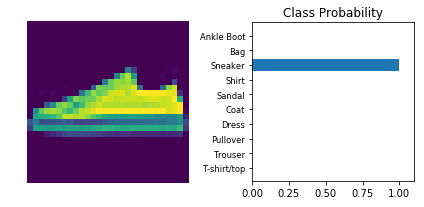

In [45]:
# Import helper module (should be in the repo)
import helper

# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.